# Training Module for Proposed Model

# Import Libraries

In [2]:
import pickle
import numpy as np
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from plib.data import get_data,minmax_norm,data_split
from plib.feature_selection import out_features
from plib.p_metric import main_perf_metrics_calc
import  plib.emodel as model

# Read and Process Dataset

In [3]:
X_train ,Y_train,train_df =get_data('./plib/dataset/Cleveland.csv')
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", Y_train.shape)
train_df.describe()

Number of rows: 302;  Number of columns: 14; No of missing values 6
Shape of X_train: (302, 13)
Shape of y_train: (302,)


,63,1,1.1,145,233,1.2,2,150,0,2.3,3,0.2
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.410596,0.678808,3.165563,131.645695,246.738411,0.145695,0.986755,149.605960,0.327815,1.035430,1.596026,0.940397
std,9.040163,0.467709,0.953612,17.612202,51.856829,0.353386,0.994916,22.912959,0.470196,1.160723,0.611939,1.229384
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000
50%,55.500000,1.000000,3.000000,130.000000,241.500000,0.000000,0.500000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


# Data Normalization

In [4]:
X_train=minmax_norm(X_train)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", Y_train.shape)
classes=len(np.unique(Y_train))
print("Classes: ",classes)

Shape of X_train: (302, 13)
Shape of y_train: (302,)
Classes:  5


# Split Data for Train and Test

In [5]:
xtrain, xvalid, ytrain, yvalid,fold=data_split(X_train,Y_train,test_size=0.2)
print("Shape of X_train:", xtrain.shape)
print("Shape of y_train:", ytrain.shape)
print("Shape of X_test:", xvalid.shape)
print("Shape of y_test:", yvalid.shape)


Shape of X_train: (241, 13)
Shape of y_train: (241,)
Shape of X_test: (61, 13)
Shape of y_test: (61,)


# Feature Selection

In [6]:
opts = {'k':5, 'fold':fold, 'N':X_train.shape[0], 'T':7, 'w':0.7, 'c1':2, 'c2':2}
x_train, x_test, y_train, y_test,b_feat= out_features(X_train,Y_train,opts,xtrain, xvalid, ytrain, yvalid)
print ("Number of Best Features: ",b_feat)

sel_feat_ratio=60
w=round(x_train.shape[1]*sel_feat_ratio/100)
print(b_feat,w)
if w > b_feat:
    x_train=x_train[:,0:  w]
    x_test=x_test[:,0:w]
    print("Seleted Feature Composition: ",x_train.shape,x_test.shape)
    print('You choosed worse features too.')
else:
    x_train=x_train[:,0:  w]
    x_test=x_test[:,0:w]
    print("Seleted Feature Composition: ",x_train.shape,x_test.shape)
encoder = LabelEncoder()
y_train=encoder.fit_transform(y_train.reshape(-1, 1))
y_test=encoder.fit_transform(y_test.reshape(-1, 1))
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print("Shape of X_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Iteration: 1
Best (PSO): 0.7557512134372929
Iteration: 2
Best (PSO): 0.7456133072314338
Iteration: 3
Best (PSO): 0.7456133072314338
Run Time --- 0.5385401248931885 seconds ---
Number of Best Features:  5
5 8
Seleted Feature Composition:  (241, 8) (61, 8)
You choosed worse features too.
Shape of X_train: (241, 8)
Shape of y_train: (241, 5)
Shape of X_test: (61, 8)
Shape of y_test: (61, 5)


# Model Training

In [9]:
net=model.ensemble_models(0,x_train, y_train,x_test,y_test,classes)
for x in range(len(net)): 
    #print("Name: ",x)
    net[x].summary()
    net[x].fit(x_train, y_train,
                  batch_size=10,
                  epochs=100,
                  validation_data=(x_test, y_test),
                  shuffle=False,verbose=0)
    net[x].save('model/ensemble.h5')
    

8
8
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 add (Add)                      (None, 8)            0           ['input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 8)            0           ['add[0][0]']                    
                                                                                                  
 add_1 (Add)                    (None, 8)            0           ['activation[0][0]',     

In [10]:
from tensorflow import keras
ensemble = keras.models.load_model('model/ensemble.h5')

loss_train,acc_train=ensemble.evaluate(x_train,y_train)
print("loss_train: ",loss_train)
print("acc_train: ",acc_train*100,"%")

8/8 [==============================] - 0s 2ms/step - loss: 0.9618 - accuracy: 0.6141
loss_train:  0.9617906808853149
acc_train:  61.41079068183899 %


# Ensemble Deep Learning

Epoch 1/100
25/25 [==============================] - 0s 2ms/step - loss: 0.9657 - accuracy: 0.6224
Epoch 2/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9766 - accuracy: 0.6017
Epoch 3/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9627 - accuracy: 0.6183
Epoch 4/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9751 - accuracy: 0.6183
Epoch 5/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9751 - accuracy: 0.6266
Epoch 6/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9671 - accuracy: 0.6058
Epoch 7/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9612 - accuracy: 0.6100
Epoch 8/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9581 - accuracy: 0.6058
Epoch 9/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9720 - accuracy: 0.6266
Epoch 10/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9641 - accuracy: 0.6349
Epoch 11/

25/25 [==============================] - 0s 1ms/step - loss: 0.9414 - accuracy: 0.6224
Epoch 84/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9445 - accuracy: 0.6349
Epoch 85/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9424 - accuracy: 0.6307
Epoch 86/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9473 - accuracy: 0.6266
Epoch 87/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9392 - accuracy: 0.6349
Epoch 88/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9397 - accuracy: 0.6349
Epoch 89/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9472 - accuracy: 0.6266
Epoch 90/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9549 - accuracy: 0.6141
Epoch 91/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9525 - accuracy: 0.6266
Epoch 92/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9387 - accuracy: 0.6307
Epoch 93/100


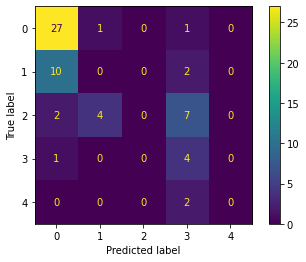

Accuracy, sensitivity, specificity, Precision, F1-score
(0.5515695067264573, 0.5081967213114754, 0.5879120879120879, 0.5081967213114754, 0.5081967213114754)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
filename = 'model/final_model.ensemble'
model = KerasClassifier(model=ensemble, epochs=100, batch_size=10, verbose=1)
model.fit(x_train, y_train)
pickle.dump(model, open(filename, 'wb'))

#load model
#model = pickle.load(open(filename, 'rb'))

y_pred=model.predict(x_test)
measures =main_perf_metrics_calc(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1),classes)
print(measures)
measures_table = dict()
measures_table['Ensemble_Train'] = measures

# Showing All performance Measures for Ensemble Classifier in Table

In [13]:
def header():
    for x in range(90):
        print ('-',end = '')
    print('')
    
header()
print ("{:<18} | {:<11} | {:<11} | {:<11} | {:<10} | {:<10}".format('Classifier','Accuracy %', 'Sensitivity', 'Specificity','Precision','F1-Score'))
 
# print each data item.
for key, value in measures_table.items():
    Acc,Sen,Spec,Prec,F1 = value
#    header()
    if key == 'GradientBoosting':
        key ='Gradient'
    print ("{:<18} | {:<11} | {:<11} | {:<11} | {:<10} | {:<10} ".format(key,round(Acc*100,3),round(Sen,3),round(Spec,3),round(Prec,3),round(F1,3)))
header()

------------------------------------------------------------------------------------------
Classifier         | Accuracy %  | Sensitivity | Specificity | Precision  | F1-Score  
Ensemble_Train     | 55.157      | 0.508       | 0.588       | 0.508      | 0.508      
------------------------------------------------------------------------------------------


# Saving Results to File

In [14]:
import os
# Create Folder for Results if not exist
if not os.path.exists('Results'):
    os.makedirs('Results')

In [15]:
#####################################################
                ## Using Pickle
################################################        
#import pickle
# Open a file and use dump()
#with open('results/NN.pkl', 'wb') as file:
    # A new file will be created
#    pickle.dump(measures_table, file)    

In [16]:
#####################################################
                ## Using CSV
################################################
# import csv
#w = csv.writer(open("Results/NN.csv", "wb"))

# loop over dictionary keys and values
#for key, val in measures_table.items():
#    print(key,val)
    # write every key and value to file
#    w.writerow([key, val])

In [17]:
#####################################################
                ## Using JSON
#####################################################
# load json module
import json

# python dictionary with key value pairs

# create json object from dictionary
json = json.dumps(measures_table)

# open file for writing, "w" 
f = open("Results/Proposed_Training.json","w")

# write json object to file
f.write(json)

# close file
f.close()